In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!rm -rf ./gdrive/Shareddrives/RoseHack/Training_Data/
!rm -rf ./gdrive/Shareddrives/RoseHack/Val_Data/

!mkdir ./gdrive/Shareddrives/RoseHack/Training_Data/
!mkdir ./gdrive/Shareddrives/RoseHack/Val_Data/
!mkdir ./gdrive/Shareddrives/RoseHack/Training_Data/Happy/
!mkdir ./gdrive/Shareddrives/RoseHack/Training_Data/Sad/
!mkdir ./gdrive/Shareddrives/RoseHack/Training_Data/Neither/
!mkdir ./gdrive/Shareddrives/RoseHack/Val_Data/Happy/
!mkdir ./gdrive/Shareddrives/RoseHack/Val_Data/Sad/
!mkdir ./gdrive/Shareddrives/RoseHack/Val_Data/Neither/

In [4]:
!ls ./gdrive/Shareddrives/RoseHack/Training_Data/Neither/

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import time
import os
import matplotlib.pyplot as plt
import time

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.keras.__version__)

2.7.0
2.7.0


In [1]:
import pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [4]:
import shutil
import os
import numpy as np

classes = ["Happy", "Sad", "Neither"]

source = "./gdrive/Shareddrives/RoseHack/Face_Data/Data/"
train = "./gdrive/Shareddrives/RoseHack/Training_Data/"
val = "./gdrive/Shareddrives/RoseHack/Val_Data/"

for c in classes:
  files = os.listdir(source + c + "/")
  for f in files:
    if np.random.rand(1)<0.9:
      shutil.copy(source + c + "/" + f, train + c + "/" + f)
    else:
      shutil.copy(source + c + "/" + f, val + c + "/" + f)


In [7]:
import shutil
import os
import numpy as np

classes = ["Happy", "Sad", "Neither"]
classes0 = ["happy", "sad", "neutral"]

train0 = "./gdrive/Shareddrives/RoseHack/NewData/train/"
val0 = "./gdrive/Shareddrives/RoseHack/NewData/test/"
train = "./gdrive/Shareddrives/RoseHack/Training_Data/"
val = "./gdrive/Shareddrives/RoseHack/Val_Data/"

for c, c0 in zip(classes, classes0):
  files = os.listdir(train0 + c0 + "/")
  for f in files:
    if np.random.rand(1)<0.25:
      shutil.copy(train0 + c0 + "/" + f, train + c + "/" + f)
  
  files1 = os.listdir(val0 + c0 + "/")
  for f1 in files1:
    if np.random.rand(1)<0.25:
      shutil.copy(val0 + c0 + "/" + f1, val + c + "/" + f1)

In [3]:
train = "./gdrive/Shareddrives/RoseHack/Training_Data/"
val = "./gdrive/Shareddrives/RoseHack/Val_Data/"

In [4]:
training_directory = train #"./gdrive/Shareddrives/RoseHack/NewData/train/"
testing_directory = val #"./gdrive/Shareddrives/RoseHack/NewData/test/"#

In [5]:
image_width, image_height = 224, 224
batch_size = 32

train_data = pathlib.Path(training_directory) 
test_data = pathlib.Path(testing_directory) 

train_ds = image_dataset_from_directory(
    train_data,
    seed = 123,
    label_mode='categorical',
    image_size = (image_width, image_height),
    batch_size = batch_size,
    color_mode = "rgb")

val_ds = image_dataset_from_directory(
    test_data,
    seed = 123,
    label_mode='categorical',
    image_size = (image_width, image_height),
    batch_size = batch_size,
    color_mode = "rgb")

Found 4216 files belonging to 3 classes.
Found 1064 files belonging to 3 classes.


In [6]:
normalization_layer = Rescaling(1./255)

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [7]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.nn import relu, softmax
from tensorflow.keras.applications import DenseNet201 # import MobileNetV3Small


def create_model():
    net = DenseNet201(include_top=False,
                      input_tensor=None,
                      input_shape=(224,224,3),
                      classes = 3)
    # net = tf.keras.applications.resnet50.ResNet50(include_top=True,
    #                                               weights=None,
    #                                               input_tensor=None,
    #                                               input_shape=None,
    #                                               classes=3)
    # net = MobileNetV3Small(input_shape=None,
    #                        include_top=True,
    #                        input_tensor=None,
    #                        dropout_rate=0.1,
    #                        weights = None,
    #                        classifier_activation='softmax',
    #                        classes = 3)
    x = net.output
    x = Flatten()(x)
    output_layer = Dense(3, activation='softmax', name='softmax')(x)
    net_final = Model(inputs=net.input, outputs=output_layer) #net.output)
    print(net_final.summary())
    return net_final

In [8]:
def train_model(num_epochs, saving_dir, validation = True):
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = create_model()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit(normalized_train_ds, validation_data=normalized_val_ds, 
                        epochs=num_epochs)
    
    if validation:

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()
    
    model.save(saving_dir)
    
    del (model)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
74850304/74836368 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                          

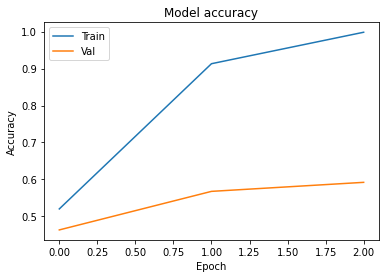

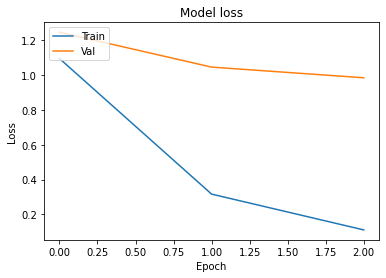

In [9]:
t = time.time()
train_model(num_epochs=3, saving_dir = "./gdrive/Shareddrives/RoseHack/Models/Model{}.h5".format(t))

In [23]:
# import os
# import shutil

# new_data_dir = "./gdrive/Shareddrives/RoseHack/NewData/train/"
# # happy = "./gdrive/Shareddrives/RoseHack/Face_Data/Data/Happy/"
# # sad = "./gdrive/Shareddrives/RoseHack/Face_Data/Data/Sad/"
# # neither = "./gdrive/Shareddrives/RoseHack/Face_Data/Data/Neither/"
# classes = os.listdir(new_data_dir)
# for c in classes:
#   path = new_data_dir + c + "/"
#   files = os.listdir(path)
#   for f in files:
#     if c != "happy" and c != "sad":
#       shutil.move(path + f, new_data_dir + "neutral/" + f)
#     # elif c == "sad":
#     #   shutil.move(path + f, sad + f)
#     # else:
#     #   shutil.move(path + f, neither + f)



In [39]:
#!ls ./gdrive/Shareddrives/RoseHack/NewData/test/ 

happy  neutral	sad


In [36]:
# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/train/disgusted/
# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/train/fearful/
# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/train/surprised/
# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/train/angry/

# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/test/disgusted/
# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/test/fearful/
# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/test/surprised/
# !rm -rf ./gdrive/Shareddrives/RoseHack/NewData/test/angry/

In [40]:
# import cv2

# img = cv2.imread("./gdrive/Shareddrives/RoseHack/NewData/train/happy/im1590.png")

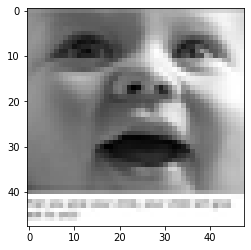

In [44]:
# import matplotlib.pyplot as plt

# plt.imshow(img0)

In [43]:
# img0 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)